### XAI (Explainable AI): 설명 가능한 AI
- ex) 딥러닝이 어떤 특징을 확인하여 이러한 결과를 도출했는지 확인

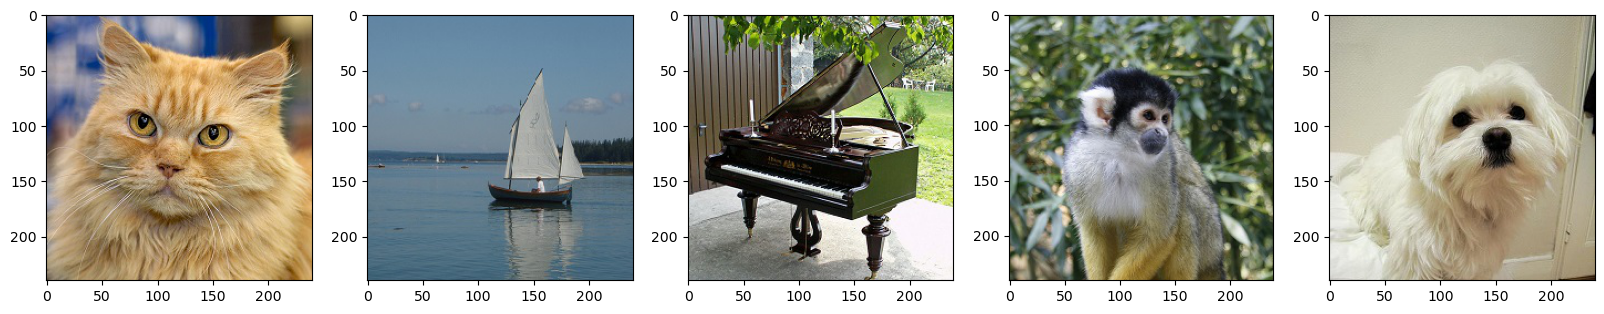

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16

# XAI 알고리즘을 불러오는 부분
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

# image를 불러와 보여 주는 데 쓰는 라이브러리
import glob 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

images_originals = []

for img_path in glob.glob('./data/img/*_0.jpg'):
    images_originals.append(mpimg.imread(img_path))

plt.figure(figsize=(20, 20))

for i, image_o in enumerate(images_originals):
    plt.subplot(5, 5, i +1)
    plt.imshow(image_o)


In [7]:
# 사전 훈련 모델 가져오기
model = VGG16(weights='imagenet', include_top = True)
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)


2.16.1
3.3.3


## 트러블슈팅
1. keras 2.15.0 버젼에서는 정상적으로 그레디언트 CAM 에 대하여 output shape 에 대한 부분을 조절하지 않아도 정상적으로 동작하였으나,  
keras 3.3.3 버젼에서는 비정상적으로 동작하는 부분 확인
    - AttributeError: 'Dense' object has no attribute 'output_shape'
2. 텐서에 대한 변환이 이루어 지지 않는 부분 확인.
    - ValueError: When providing `inputs` as a list/tuple, all values in the list/tuple must be KerasTensors. Received: inputs=[[<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_1886>]] including invalid value [<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_1886>] of type <class 'list'>


- 해결
1. 사전훈련모델의 마지막 Convolution 의 layer 이름을 명시
2. tensor 만 전달할 수 있도록 라이브러리를 활용하지 않고 그레디언트 CAM 대한 함수를 사용하여 직접 구현

In [107]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16

# XAI 알고리즘을 불러오는 부분
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

# image를 불러와 보여 주는 데 쓰는 라이브러리
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# 사전 훈련 모델 가져오기
model = VGG16(weights='imagenet', include_top=True)

input_list = ["maltese", "persian_cat", "squirrel_monkey", "grand_piano", "yawl"]
imagenet_index = ["153", "283", "382", "579", "914"]

# 그레디언트 CAM 알고리즘 선택
explainer = GradCAM()

# 그레디언트 CAM 알고리즘이 적용된 이미지가 들어갈 빈 리스트 만들기
images_cams = []

# 그레디언트 CAM 알고리즘 실행
for l, i in zip(input_list, imagenet_index):
    # 이미지를 불러와 내부에서 처리될 이미지의 크기 설정
    img = load_img(f'./data/img/{l}_0.jpg', target_size=(224, 224))
    img = img_to_array(img)  # 이미지를 넘파이 배열로 변환
    img = np.expand_dims(img, axis=0)  # 배치 차원 추가

    # 그레디언트 CAM 실행되는 부분
    grid = explainer.explain((img, None), model, int(i), layer_name='block5_conv3')
    
    # 실행 후 저장되는 이름
    explainer.save(grid, ".", f'./data/img/{l}_cam.jpg')

plt.figure(figsize=(15, 15))

for img_path in glob.glob('./data/img/*_cam.jpg'):
    images_cams.append(mpimg.imread(img_path))

for i, image_c in enumerate(images_cams):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_c)

plt.show()


AttributeError: 'Dense' object has no attribute 'output_shape'

/var/folders/f7/gl6wpvqx5z596rbpjsq5n3tc0000gn/T/ipykernel_90758/4146209027.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


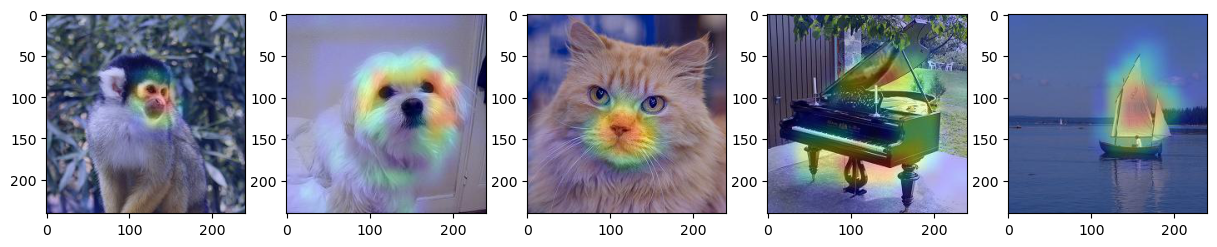

In [105]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16

def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# 그레디언트 CAM 모델 훈련 및 히트맵 표기
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = load_img(img_path)
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    # plt.imshow(superimposed_img)
    # plt.axis('off')
    # plt.show()

# 사전 훈련 모델 가져오기
model = VGG16(weights='imagenet')

input_list = ["maltese", "persian_cat", "squirrel_monkey", "grand_piano", "yawl"]
imagenet_index = [153, 283, 382, 579, 914]

for l, i in zip(input_list, imagenet_index):
    img_path = f'./data/img/{l}_0.jpg'
    img_array = get_img_array(img_path, size=(224, 224))
    img_tensor = tf.convert_to_tensor(img_array)
    heatmap = make_gradcam_heatmap(img_tensor, model, 'block5_conv3', pred_index=i)
    save_and_display_gradcam(img_path, heatmap, cam_path=f'./data/img/{l}_cam.jpg')

plt.figure(figsize=(15, 15))

for img_path in glob.glob('./data/img/*_cam.jpg'):
    images_cams.append(mpimg.imread(img_path))

for i, image_c in enumerate(images_cams):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_c)

plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step


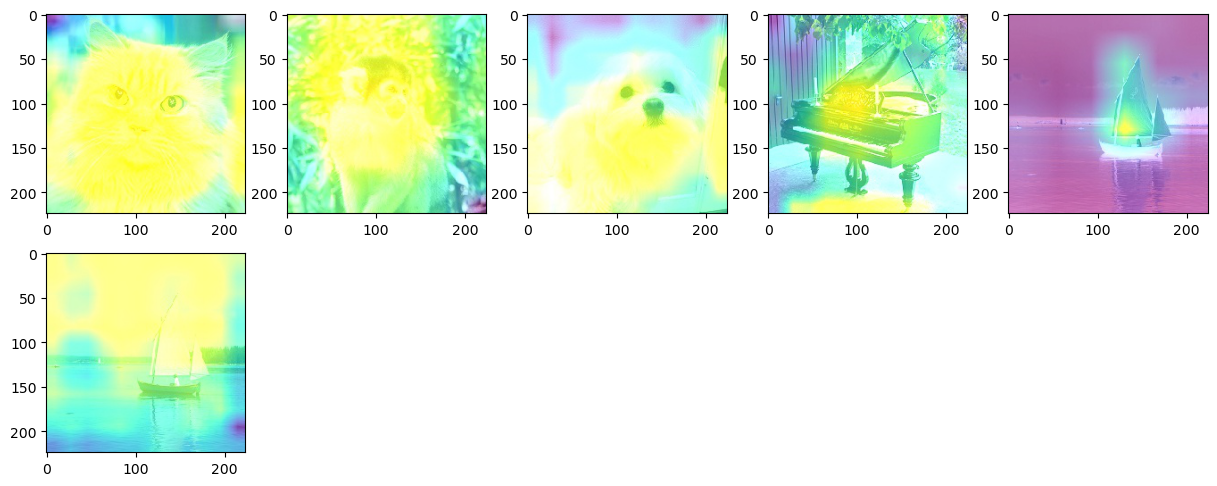

In [26]:
# 사전 훈련 모델 가져오기
model = VGG16(weights='imagenet', include_top=True)

input_list = ["maltese", "persian_cat", "squirrel_monkey", "grand_piano", "yawl"]
imagenet_index = ["153", "283", "382", "579", "914"]

# 오클루전 알고리즘 선택
explainer = OcclusionSensitivity()

# 오클루전 알고리즘 적용 이미지 들어갈 빈 리스트 만들기
images_occ1s = []

# 패치 크기
patch_size = 20

# 오클루전 알고리즘 실행
for l, i in zip(input_list, imagenet_index):
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224, 224))
    img = img_to_array(img)  # 이미지를 넘파이 배열로 변환
    img = np.expand_dims(img, axis=0)  # 배치 차원 추가
    img = img / 255.0  # 스케일링

    # 오클루전 알고리즘 실행되는 부분
    grid = explainer.explain((img, None), model, int(i), patch_size)
    explainer.save(grid, ".", './data/img/{}_occ1.jpg'.format(l))

plt.figure(figsize=(10, 15))

for img_path in glob.glob('./data/img/*_occ1.jpg'):
    images_occ1s.append(mpimg.imread(img_path))

for i, image_o in enumerate(images_occ1s):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_o)

plt.show()